# A Symmetric Junction Model

The previously simulated memristic nanowire network used asymmetric junctions---that is, switches that decreased in resistance from one current, but increased in resistance with the opposite. However, the construction of PVP/Ag nanowires is symmetric. It seems reasonable to assume that, if resistance decreases by ion bridge forming by current, any current, in any direction, will do so. Electromigration.

They say the junctions dissolve over time. Thus, we propose the following model, kinda ungrounded in physical reality:

First, as before, in a junction,

$$V=\left[R_{on}\cdot\frac{w}{w_0} + R_{off}\cdot*\left(1-\frac{w}{w_0}\right)\right]\cdot I,$$

just as before, and, differently,

$$\frac{dw}{dt} = \mu_v\cdot\frac{R_{on}}{w_0}\cdot|I| - \tau\cdot w - \eta,$$

where all variables are the same as before. That is, $w_0$ is the total junction width (m), $w$ is the current width of the ion bridge inside the junction (m) ($w\in[0,w_0]$), $R_{on}$ and $R_{off}$ (Ω) are the resistances of the total junction when bridged or empty, respectively, $V$ (V) and $I$ (A) are the current through the junction, $\mu_v$ is the ion mobility ($m^2/(s*V)$), and $\eta$ is noise defined by a normal distribution with mean zero and standard deviation proportional to $\frac{dw}{dt}$ meant to model ion availability.

Let's see how this acts using the previously developed functions, modified for this model.

In [1]:
import math
import random
import matplotlib.pyplot as pyplot
import matplotlib.patches as patches
import numpy
import timeit

class Nanowire:

    def __init__(self, start, end):
        self.x1, self.y1 = start
        self.x2, self.y2 = end
        self.voltage = 0
        self.junctions = []

class Junction:

    def __init__(self, position, start, end, ron, roffron, wmax, mobility, dissolution_rate, roffron_sigma, wmax_sigma, alpha_sigma, w0=0.5):
        
        # topological characteristics
        self.x, self.y = position
        self.nanowires = [start, end]
        
        # physical characteristics
        self.current = 0 # current from start to end nanowire
        self.ron = ron; self.roff = ron*random.gauss(roffron, roffron*roffron_sigma) # resistance of switch on and off states (ohm)
        self.wmax = random.gauss(wmax, wmax*wmax_sigma) # current width and maximum width of ionic bridge (m)
        self.w = self.wmax*w0 # current width of junction
        self.mobility = mobility # ionic mobility (m^2/(s*V))
        self.dissolution_rate = dissolution_rate; # rate of dissolution of bridge (1/s)
        self.alpha_sigma = alpha_sigma # standard deviation of noise as fraction of dw/dt
        self.last_dwdt=0
        
    def resistance(self):
        return (self.ron*(self.w/self.wmax) + self.roff*(1-self.w/self.wmax))
    
    def dwdt(self):
        self.last_dwdt = self.mobility*self.ron/self.wmax*abs(self.current) - self.dissolution_rate*(self.w) + random.gauss(0, self.last_dwdt*self.alpha_sigma)
        return self.last_dwdt
    
    def update_w(self, timestep):
        self.w += self.dwdt()*timestep
        if self.w < 0:
            self.w = 0
        if self.w > self.wmax:
            self.w = self.wmax

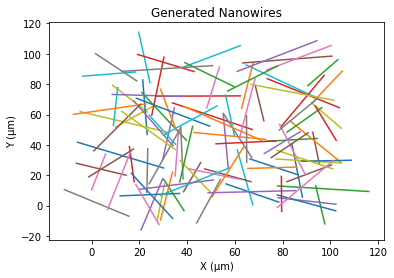

In [2]:
"""
Creates a set of nanowires, randomly and uniformly positioned within the given constraints, and returns the set as a list.

num_nanowires : the number of nanowires to create
xmin / xmax / ymin / ymax : the bounding box, in units of micrometers, of the centerpoints of the nanowires
lmin / lmax : the minimum and maximum allowed lengths of the nanowires, respectively
seed : seed to initialize the random number generator
"""
def spawn_nanowires(num_nanowires=100, xmin=0, xmax=100, ymin=0, ymax=100, lmin=20, lmax=40, seed=1):
    nanowires = [] # will store nanowires
    random.seed(seed) # be kinda deterministic
    
    for i in range(num_nanowires):

        # Generate nanowire start and end points.
        # Note that center of nanowire is inside boundary:
        # the nanowire can rotate to leave boundary---
        # if this were not allowed, one would have an abnormal
        # buildup of nanowires parallel to and next to each wall.
        new_length = random.uniform(lmin, lmax)
        new_angle =  random.uniform(0, math.pi)
        new_dxmax =  math.cos(new_angle)*new_length/2
        new_dymax =  math.sin(new_angle)*new_length/2
        new_dxmin = -math.cos(new_angle)*new_length/2
        new_dymin = -math.sin(new_angle)*new_length/2
        new_x     =  random.uniform(xmin, xmax)
        new_y     =  random.uniform(ymin, ymax)
        new_start =  new_x+new_dxmin, new_y+new_dymin
        new_end   =  new_x+new_dxmax, new_y+new_dymax

        nanowires.append(Nanowire(new_start, new_end))
    
    return nanowires
        
# test network creation

network = spawn_nanowires()

for nanowire in network:
    pyplot.plot([nanowire.x1, nanowire.x2], [nanowire.y1, nanowire.y2])
pyplot.title("Generated Nanowires")
pyplot.xlabel("X (µm)")
pyplot.ylabel("Y (µm)")
pyplot.show()

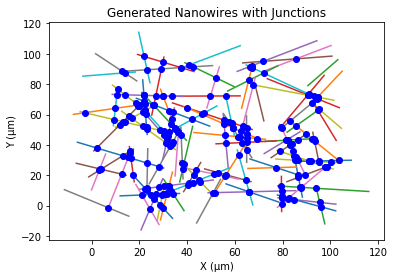

In [3]:
def create_junctions(network, electrodes=[], ron=5e3, roffron=1e3, wmax=5e-9, mobility=0.5e-12, dissolution_rate=1e-1, roffron_sigma=0, wmax_sigma=0, alpha_sigma=0, w0=0.5, seed=1):
    """Given array of Nanowire, returns array of junctions and correspondingly updates Nanowire array objects."""
    junctions = [] # will store junctions
    
    random.seed(seed) # be kinda deterministic

    for i, nanowire in enumerate(network):
        # obtain min and max coordinates for bouding box
        nxmin = min(nanowire.x1, nanowire.x2); nymin = min(nanowire.y1, nanowire.y2)
        nxmax = max(nanowire.x1, nanowire.x2); nymax = max(nanowire.y1, nanowire.y2)
        # and get start and end points (not necessarily the min/max box corners) with shorter names
        nx1 = nanowire.x1; ny1 = nanowire.y1
        nx2 = nanowire.x2; ny2 = nanowire.y2
        for j, other in enumerate(network):
            if j <= i: # avoid duplicate comparisons
                continue
            # as before...
            oxmin = min(other.x1, other.x2); oxmax = max(other.x1, other.x2)
            oymin = min(other.y1, other.y2); oymax = max(other.y1, other.y2)
            ox1 = other.x1; oy1 = other.y1
            ox2 = other.x2; oy2 = other.y2
            # first compare bouding boxes of nanowires for a collision
            if nxmax >= oxmin and nxmin <= oxmax:
                if nymax >= oymin and nymin <= oymax:
                    # if there is an intersection, find its location
                    if nx2 == nx1: # prevent division by zero
                        nx2 = nx1+1e-10
                    if ox2 == ox1: # ~
                        ox2 = ox1+1e-10
                    nslope = (ny2-ny1)/(nx2-nx1)
                    oslope = (oy2-oy1)/(ox2-ox1)
                    if nslope == oslope: # prevent division by zero
                        nslope = oslope+1e-10
                    intx = (nx1*nslope-ny1-ox1*oslope+oy1)/(nslope-oslope)
                    inty = (nx1*nslope*oslope-ny1*oslope-(ox1*oslope-oy1)*nslope)/(nslope-oslope)
                    # if the intersection is still within the bounding boxes, it's a junction!
                    if nxmin <= intx <= nxmax and nymin <= inty <= nymax:
                        if oxmin <= intx <= oxmax and oymin <= inty <= oymax:
                            on_same_electrode = False
                            for electrode in electrodes: # ignore the junction if nanowires are connected to same electrode
                                if i in electrode.nanowires and j in electrode.nanowires:
                                    on_same_electrode = True
                            if not on_same_electrode:
                                network[i].junctions.append(len(junctions))
                                network[j].junctions.append(len(junctions))
                                first = i; second = j
                                if random.choice([True, False]): # randomize polarity of junction
                                    first = j; second = i
                                junctions.append(Junction((intx, inty), first, second, ron=ron, roffron=roffron, wmax=wmax, mobility=mobility,
                                                          dissolution_rate=dissolution_rate, roffron_sigma=roffron_sigma, wmax_sigma=wmax_sigma, alpha_sigma=alpha_sigma, w0=w0))
    
    return junctions

network = spawn_nanowires()
junctions = create_junctions(network)
for nanowire in network:
    pyplot.plot([nanowire.x1, nanowire.x2], [nanowire.y1, nanowire.y2])
for junction in junctions:
    pyplot.plot([junction.x], [junction.y], 'bo')
pyplot.title("Generated Nanowires with Junctions")
pyplot.xlabel("X (µm)")
pyplot.ylabel("Y (µm)")
pyplot.show()

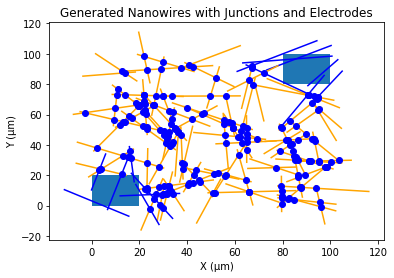

In [4]:
class Electrode:
    
    def __init__(self, x, y, width, height):
        self.x = x; self.y = y
        self.width = width; self.height = height
        self.nanowires = []
        self.voltage = 0
        
def connect_electrodes(electrodes, network):
    """Takes array of Electrode and array of Nanowire ; adds intersecting Nanowire indices to electrodes."""
    for i, electrode in enumerate(electrodes):
        # obtain min and max coordinates for bouding box
        exmin = electrode.x; exmax = electrode.x + electrode.width
        eymin = electrode.y; eymax = electrode.y + electrode.height
        for j, nanowire in enumerate(network):
            # obtain min and max coordinates for bouding box
            nxmin = min(nanowire.x1, nanowire.x2); nymin = min(nanowire.y1, nanowire.y2)
            nxmax = max(nanowire.x1, nanowire.x2); nymax = max(nanowire.y1, nanowire.y2)
            # and get start and end points (not necessarily the min/max box corners) with shorter names
            nx1 = nanowire.x1; ny1 = nanowire.y1
            nx2 = nanowire.x2; ny2 = nanowire.y2
            if nxmax >= exmin and nxmin <= exmax:
                if nymax >= eymin and nymin <= eymax:
                    rectpoints = [(exmin, eymin), (exmin, eymax), (exmax, eymin), (exmax, eymax)]
                    gtz = False; ltz = False
                    for point in rectpoints: # determine whether rectangle overlaps line by corners
                        x3, y3 = point
                        sign = (nx2-nx1)*(y3-ny1)-(x3-nx1)*(ny2-ny1) # calculate z of cross product of line-line and line-rectpoint vectors
                        if sign < 0: # For the rectangle and line to overlap, at least one point should have a negative cross product,
                            ltz = True
                        if sign > 0: # and at least one point should have the opposite (positive).
                            gtz = True
                    if gtz and ltz: # there's a rectangle corner on each side of the line, so they intersect
                        electrode.nanowires.append(j)

electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
network = spawn_nanowires()
connect_electrodes(electrodes, network)
junctions = create_junctions(network, electrodes=electrodes)
for i, nanowire in enumerate(network):
    color = 'orange'
    for electrode in electrodes:
        if i in electrode.nanowires:
            color = 'blue'
            break
    pyplot.plot([nanowire.x1, nanowire.x2], [nanowire.y1, nanowire.y2], color=color)
for junction in junctions:
    pyplot.plot([junction.x], [junction.y], 'bo')
for electrode in electrodes:
    pyplot.gca().add_patch(patches.Rectangle((electrode.x, electrode.y), electrode.width, electrode.height))
pyplot.title("Generated Nanowires with Junctions and Electrodes")
pyplot.xlabel("X (µm)")
pyplot.ylabel("Y (µm)")
pyplot.show()

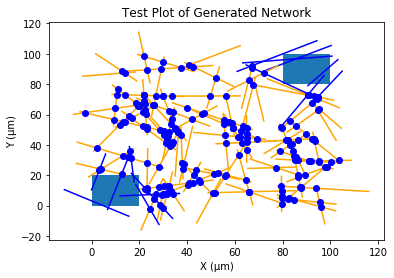

In [5]:
def plot_network(nanowires, junctions, electrodes, title):
    for i, nanowire in enumerate(nanowires):
        color = 'orange'
        for electrode in electrodes:
            if i in electrode.nanowires:
                color = 'blue'
                break
        pyplot.plot([nanowire.x1, nanowire.x2], [nanowire.y1, nanowire.y2], color=color)
    for junction in junctions:
        pyplot.plot([junction.x], [junction.y], 'bo')
    for electrode in electrodes:
        pyplot.gca().add_patch(patches.Rectangle((electrode.x, electrode.y), electrode.width, electrode.height))
    pyplot.title(title)
    pyplot.xlabel("X (µm)")
    pyplot.ylabel("Y (µm)")
    pyplot.show()
    
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
nanowires = spawn_nanowires()
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes)
plot_network(nanowires, junctions, electrodes, "Test Plot of Generated Network")

[1, 0]


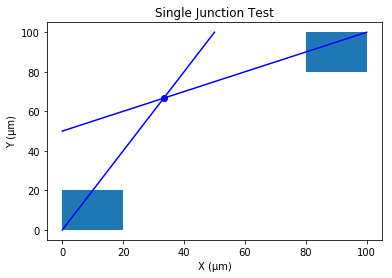

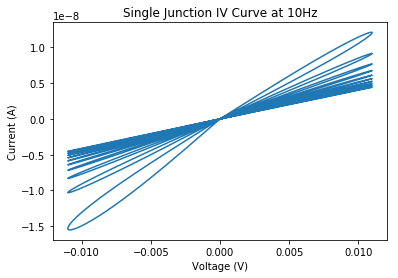

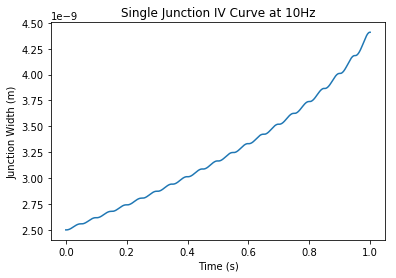

In [6]:
# create network
nanowires = [Nanowire((0,0),(50, 100)), Nanowire((100,100), (0, 50))]
junctions = []
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes)
junctions[0].alpha_sigma = 0
print(junctions[0].nanowires)
plot_network(nanowires, junctions, electrodes, "Single Junction Test")
        
# simulate sinusoidal input
times = []
voltages = []
currents = []
widths = []
frequency = 10 # Hz
amplitude = 0.011 # V (0 to peak)
timestep = 0.00001 # 1 ms
total_time = 1 # s
current_time = 0
while current_time <= total_time:
    # set known voltages
    electrodes[0].voltage = 0
    electrodes[1].voltage = amplitude*math.sin(current_time*frequency*2*math.pi)
    for nw_index in electrodes[0].nanowires:
        nanowires[nw_index].voltage = electrodes[0].voltage
    for nw_index in electrodes[1].nanowires:
        nanowires[nw_index].voltage = electrodes[1].voltage
    # solve for currents
    junctions[0].current = (nanowires[1].voltage - nanowires[0].voltage) / junctions[0].resistance()
    # store data
    times.append(current_time)
    voltages.append(electrodes[1].voltage)
    currents.append(junctions[0].current)
    widths.append(junctions[0].w)
    junctions[0].update_w(timestep)
    current_time += timestep
    
pyplot.plot(voltages, currents)
pyplot.xlabel('Voltage (V)')
pyplot.ylabel('Current (A)')
pyplot.title('Single Junction IV Curve at 10Hz')
pyplot.show()
pyplot.plot(times, widths)
pyplot.xlabel('Time (s)')
pyplot.ylabel('Junction Width (m)')
pyplot.title('Single Junction IV Curve at 10Hz')
pyplot.show()

Well, that's definitely a memristor, albeit very much weaker than the previous model.

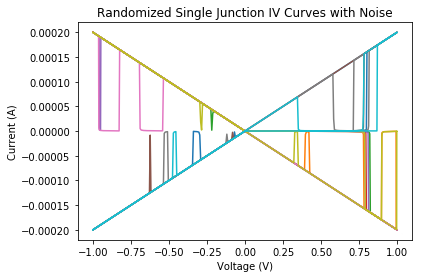

In [7]:
for i in range(10):
    
    # create network
    nanowires = [Nanowire((0,0),(50, 100)), Nanowire((100,100), (0, 50))]
    junctions = []
    electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
    connect_electrodes(electrodes, nanowires)
    # ron=5e3, roffron=1e3, wmax=5e-9, mobility=0.5e-12, dissolution_rate=1e-2, roffron_sigma=0, wmax_sigma=0, alpha_sigma=0))
    junctions = create_junctions(nanowires, electrodes=electrodes, roffron_sigma=0.05, wmax_sigma=0.01, alpha_sigma=0.3, seed=i)

    # simulate sinusoidal input
    times = []
    voltages = []
    currents = []
    frequency = 10 # Hz
    amplitude = 1 # V (0 to peak)
    timestep = 0.0001 # 0.1 ms
    current_time = 0
    while current_time <= 1/frequency+timestep:
        # set known voltages
        electrodes[0].voltage = 0
        electrodes[1].voltage = amplitude*math.sin(current_time*frequency*2*math.pi)
        for nw_index in electrodes[0].nanowires:
            nanowires[nw_index].voltage = electrodes[0].voltage
        for nw_index in electrodes[1].nanowires:
            nanowires[nw_index].voltage = electrodes[1].voltage
        # solve for currents
        junctions[0].current = (nanowires[junctions[0].nanowires[1]].voltage - nanowires[junctions[0].nanowires[0]].voltage) / junctions[0].resistance()
        # store data
        times.append(current_time)
        voltages.append(electrodes[1].voltage)
        currents.append(junctions[0].current)
        junctions[0].update_w(timestep)
        current_time += timestep

    pyplot.plot(voltages, currents)
    
pyplot.xlabel('Voltage (V)')
pyplot.ylabel('Current (A)')
pyplot.title('Randomized Single Junction IV Curves with Noise')
pyplot.show()

That works, but experimentation shows the system is very sensitive to noise. Network parameters may have to be chosen very carefully.

Next, test automatic ion bridge dissolution.

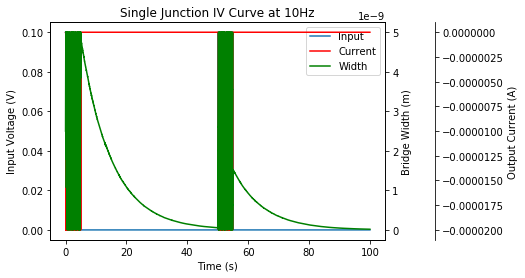

In [8]:
# create network
nanowires = [Nanowire((0,0),(50, 100)), Nanowire((100,100), (0, 50))]
junctions = []
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes, alpha_sigma=1)
        
# simulate sinusoidal input
times = []
voltages = []
inputs = []
currents = []
ws = []
timestep = 0.0001 # 1 ms
current_time = 0
def input_function(t):
    """Define input voltage"""
    if t < 5:
        return 0.1 # V
    if t < 50:
        return 0 # V
    if t < 55:
        return 0.1 # V
    return 0 # V
    
while current_time <= 100: # run for 2 s
    # set known voltages
    electrodes[0].voltage = 0
    electrodes[1].voltage = input_function(current_time)
    inputs.append(input_function(current_time))
    for nw_index in electrodes[0].nanowires:
        nanowires[nw_index].voltage = electrodes[0].voltage
    for nw_index in electrodes[1].nanowires:
        nanowires[nw_index].voltage = electrodes[1].voltage
    # solve for currents
    junctions[0].current = (nanowires[junctions[0].nanowires[1]].voltage - nanowires[junctions[0].nanowires[0]].voltage) / junctions[0].resistance()
    # store data
    times.append(current_time)
    voltages.append(electrodes[1].voltage)
    currents.append(junctions[0].current)
    ws.append(junctions[0].w)
    junctions[0].update_w(timestep)
    current_time += timestep
    
fig = pyplot.figure()
host = fig.add_subplot(111)
p1, = host.plot(times, inputs, label='Input')
outputs = host.twinx()
p2, = outputs.plot(times, currents, color="red", label='Current')
outputs.set_ylabel('Output Current (A)')
widths = host.twinx()
p3, = widths.plot(times, ws, color="green", label="Width")
widths.set_ylabel('Bridge Width (m)')
outputs.spines['right'].set_position(('outward', 50))
host.set_xlabel('Time (s)')
host.set_ylabel('Input Voltage (V)')
host.set_title('Single Junction IV Curve at 10Hz')
host.legend(handles=[p1, p2, p3])
pyplot.show(host)

Those are very sharp state changes. This is probably caused by the large resistance gap:

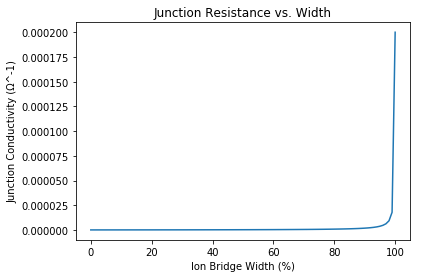

In [7]:
widths = []
resistances = []
junction = Junction((0,0), 0, 0, ron=5e3, roffron=1e3, wmax=5e-9, mobility=0.5e-12, dissolution_rate=1e-1, roffron_sigma=0, wmax_sigma=0, alpha_sigma=0)
for width in numpy.linspace(0, 100, 100):
    junction.w = junction.wmax*width/100
    widths.append(width)
    resistances.append(1/junction.resistance())

pyplot.plot(widths, resistances)
pyplot.xlabel('Ion Bridge Width (%)')
pyplot.ylabel('Junction Conductivity (Ω^-1)')
pyplot.title('Junction Resistance vs. Width')
pyplot.show()

Yep.

Next, implement a two-junction system. This will lay most of the groundwork for scaleable simultaneous equation solving.

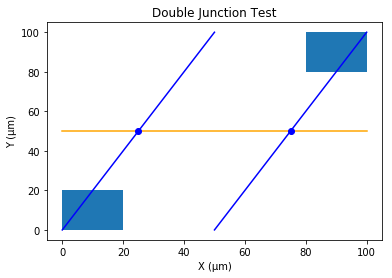

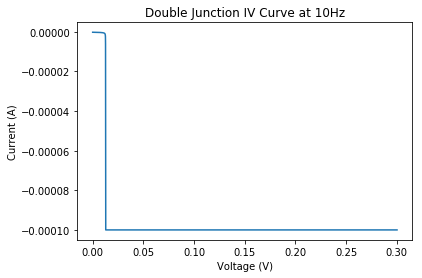

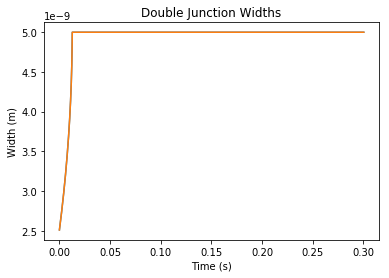

In [16]:
# create network
nanowires = [Nanowire((0,0),(50, 100)), Nanowire((100,100), (50, 0)), Nanowire((0, 50), (100,50))]
junctions = []
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes)
junctions[1].nanowires = [2,1]
plot_network(nanowires, junctions, electrodes, "Double Junction Test")

# simulate sinusoidal input
times = []
voltages = []
currents = []
w0 = []
w1 = []
frequency = 10 # Hz
amplitude = 1 # V (0 to peak)
timestep = 0.0001 # 1 ms
current_time = 0
while current_time <= (1/frequency+timestep)*3:

    # set known voltages
    electrodes[0].voltage = 0
    electrodes[1].voltage = amplitude#*math.sin(current_time*frequency*2*math.pi)

    # calculate voltages
    array = numpy.zeros((len(nanowires), len(nanowires))) # create an n by n+1 array
    weights = numpy.zeros(len(nanowires))
    for i, nanowire in enumerate(nanowires):
        for electrode in electrodes:
            if i in electrode.nanowires:
                array[i][i] = 1
                weights[i] = electrode.voltage
                break
        else:
            for j in nanowire.junctions:
                resistance = junctions[j].resistance()
                othernanowire = junctions[j].nanowires[(junctions[j].nanowires.index(i)+1)%2]
                array[i][i] += resistance
                array[i][othernanowire] -= resistance
    solution = numpy.linalg.lstsq(array, weights)[0]
    for i in range(len(nanowires)):
        nanowires[i].voltage = solution[i]

    # solve for currents
    for i in range(len(junctions)):
        ns = junctions[i].nanowires
        junctions[i].current = (nanowires[ns[1]].voltage - nanowires[ns[0]].voltage) / junctions[i].resistance()
        junctions[i].update_w(timestep)

    # store data
    times.append(current_time)
    voltages.append(electrodes[1].voltage)
    currents.append(junctions[0].current)
    w0.append(junctions[0].w)
    w1.append(junctions[1].w)
    current_time += timestep
    

    
#pyplot.plot(voltages, currents)
pyplot.plot(times, currents)
pyplot.xlabel('Voltage (V)')
pyplot.ylabel('Current (A)')
pyplot.title('Double Junction IV Curve at 10Hz')
pyplot.show()
pyplot.plot(times, w0)
pyplot.plot(times, w1)
pyplot.xlabel('Time (s)')
pyplot.ylabel('Width (m)')
pyplot.title('Double Junction Widths')
pyplot.show()

The junctions have asymmetry, thus the opposite behavior of the junctions. I don't like it, but I don't see an immediate solution. I'll think about it.

It is time to attempt to replicate simple results of "A theoretical and experimental study of neuromorphic atomic switch networks for reservoir computing" (Gimzerwski et al. 2013).

In [8]:
def update_network(nanowires, junctions, electrodes, timestep):
    # calculate voltages
    array = numpy.zeros((len(nanowires), len(nanowires))) # create an n by n+1 array
    weights = numpy.zeros(len(nanowires))
    for i, nanowire in enumerate(nanowires):
        for electrode in electrodes:
            if i in electrode.nanowires:
                array[i][i] = 1
                weights[i] = electrode.voltage
                break
        else:
            for j in nanowire.junctions:
                resistance = junctions[j].resistance()
                othernanowire = junctions[j].nanowires[(junctions[j].nanowires.index(i)+1)%2]
                array[i][i] += 1/resistance
                array[i][othernanowire] -= 1/resistance
    solution = numpy.linalg.lstsq(array, weights)[0]
    
    for i in range(len(nanowires)):
        nanowires[i].voltage = solution[i]
       
    # solve for currents
    for i in range(len(junctions)):
        ns = junctions[i].nanowires
        junctions[i].current = (nanowires[ns[1]].voltage - nanowires[ns[0]].voltage) / junctions[i].resistance()
        junctions[i].update_w(timestep)
        
def calculate_current_from_electrode(electrode, nanowires, junctions):
    # if the voltage at an electrode is higher than the voltage away from the electrode, then there will be positive current flowing away from it
    # the current through a junction is recorded as (voltage[1]-voltage[0])/resistance
    # so if the electrode is at voltage[1], the current through the junction should be added to the total sum of current from the electrode
    current = 0
    for i in electrode.nanowires:
        nanowire = nanowires[i]
        for j in nanowire.junctions:
            junction = junctions[j]
            if junction.nanowires[0] == i:
                current -= junction.current
            else:
                current += junction.current
    return current

In [27]:
# create network
nanowires = spawn_nanowires()
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 0, 20, 20)]
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes, w0=0.2, dissolution_rate=1)
if amplitude == 1:
    plot_network(nanowires, junctions, electrodes, "Replication Test")
# simulate sinusoidal input
times = []
voltages = []
currents = []
jweights = []
jcurrents = []
jvoltages = []
for junction in junctions:
    jweights.append([])
    jcurrents.append([])
timestep = 0.001 # 1 ms
current_time = 0
total_time = 1.5 #s
count = 0
print('Running simulation...')
while current_time < total_time:
    #if(count % 100 == 0):
    #    print('{}s / {}s...'.format(total_time, current_time))
    count += 1

    # set known voltages
    electrodes[0].voltage = 0 
    if current_time <= 0.5:
        electrodes[1].voltage = 1
    elif current_time <= 1:
        electrodes[1].voltage = 0
    elif current_time <= 1.5:
        electrodes[1].voltage = 1

    update_network(nanowires, junctions, electrodes, timestep)

    # store data
    times.append(current_time)
    voltages.append(electrodes[1].voltage)
    for i in range(len(junctions)):
        jweights[i].append(junctions[i].w)
        jcurrents[i].append(junctions[i].current)
    current = calculate_current_from_electrode(electrodes[1], nanowires, junctions)
    currents.append(current)
    jvoltages.append([])
    for i in range(len(nanowires)):
        jvoltages[-1].append(nanowires[i].voltage)
    current_time += timestep

print('Simulation complete.')

Running simulation...


/usr/lib/python3/dist-packages/ipykernel/__main__.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Simulation complete.


(1501, 100)


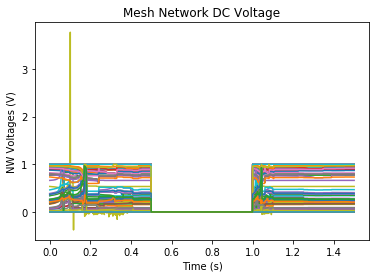

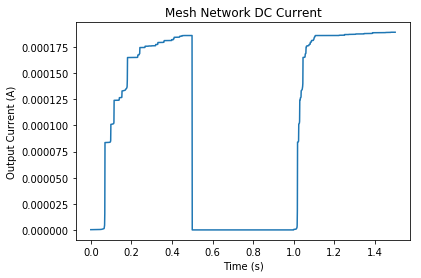

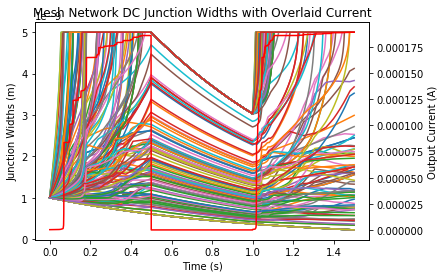

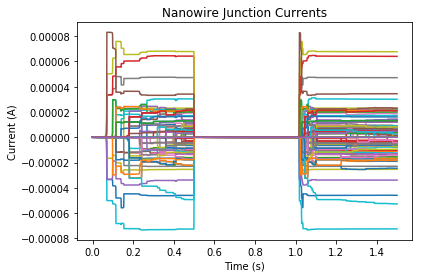

In [29]:
jvoltages = numpy.array(jvoltages)
print(jvoltages.shape)
for i in range(len(jvoltages[0])):
    pyplot.plot(times, jvoltages[:,i])
pyplot.ylabel('NW Voltages (V)')
pyplot.xlabel('Time (s)')
pyplot.title('Mesh Network DC Voltage')
pyplot.show()

pyplot.plot(times, currents)
pyplot.ylabel('Output Current (A)')
pyplot.xlabel('Time (s)')
pyplot.title('Mesh Network DC Current')
pyplot.show()

fig = pyplot.figure()
host = fig.add_subplot(111)
for i in range(len(junctions)):
    host.plot(times, jweights[i])
outputs = host.twinx()
outputs.plot(times, currents, color="red")
outputs.set_ylabel('Output Current (A)')
#outputs.spines['right'].set_position(('outward', 50))
host.set_xlabel('Time (s)')
host.set_ylabel('Junction Widths (m)')
host.set_title('Mesh Network DC Junction Widths with Overlaid Current')
pyplot.show(host)

for i in range(len(junctions)):
    pyplot.plot(times, jcurrents[i])
pyplot.title("Nanowire Junction Currents")
pyplot.xlabel('Time (s)')
pyplot.ylabel('Current (A)')
pyplot.show()

Measure the PSD:

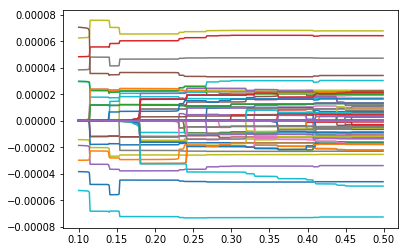

In [12]:
stimes = times[100:500]
scurrents = []
for j in jcurrents:
    s = (j[:])[100:500]
    scurrents.append(s)
    pyplot.plot(stimes, s)
pyplot.show()

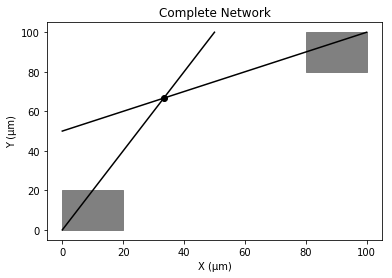

In [19]:
def scale(num, min, max):
    """Fits num to [min, max] and scales to [0, 1]"""
    if num < min:
        num = min
    if num > max:
        num = max
    return (num-min)/(max-min)
def plot_network(nanowires, junctions, electrodes, title):
    for i, nanowire in enumerate(nanowires):
        color = 'orange'
        for electrode in electrodes:
            if i in electrode.nanowires:
                color = 'blue'
                break
        pyplot.plot([nanowire.x1, nanowire.x2], [nanowire.y1, nanowire.y2], color="black",)
    for index, junction in enumerate(junctions):
        pyplot.plot([junction.x], [junction.y], 'bo', color=(scale(abs(currents[index]), 0, 0.00008), 0, 0))
    for electrode in electrodes:
        pyplot.gca().add_patch(patches.Rectangle((electrode.x, electrode.y), electrode.width, electrode.height, color="gray"))
    pyplot.title(title)
    pyplot.xlabel("X (µm)")
    pyplot.ylabel("Y (µm)")
    pyplot.show()

plot_network(nanowires, junctions, electrodes, "Complete Network")

In [82]:
def triangle_wave(time, amplitude=1, period=1):
    """Calculate value of triangular wave at given point."""
    while time > period:
        time -= period
    if time < period/2:
        return (2*time/period) * amplitude
    else:
        return (2*(1-time/period)) * amplitude
    
# create network
nanowires = spawn_nanowires()
electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
connect_electrodes(electrodes, nanowires)
junctions = create_junctions(nanowires, electrodes=electrodes, w0=0.2, dissolution_rate=1)
if amplitude == 1:
    plot_network(nanowires, junctions, electrodes, "Replication Test")
# simulate sinusoidal input
times = []
voltages = []
currents = []
jweights = []
jcurrents = []
for junction in junctions:
    jweights.append([])
    jcurrents.append([])
timestep = 0.001 # 1 ms
current_time = 0
total_time = 1.5 #s
count = 0
print('Running simulation...')
while current_time <= total_time:
    #if(count % 100 == 0):
    #    print('{}s / {}s...'.format(total_time, current_time))
    count += 1

    # set known voltages
    electrodes[0].voltage = 0 
    electrodes[1].voltage = triangle_wave(current_time, amplitude=1, period=.5)

    update_network(nanowires, junctions, electrodes, timestep)

    # store data
    times.append(current_time)
    voltages.append(electrodes[1].voltage)
    for i in range(len(junctions)):
        jweights[i].append(junctions[i].w)
        jcurrents[i].append(junctions[i].current)
    current = calculate_current_from_electrode(electrodes[1], nanowires, junctions)
    currents.append(current)
    current_time += timestep

print('Simulation complete.')

Running simulation...
Simulation complete.


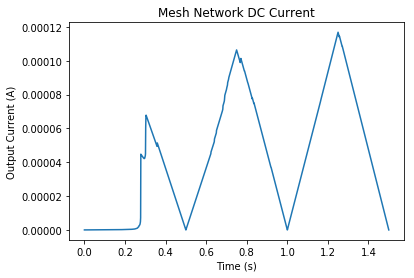

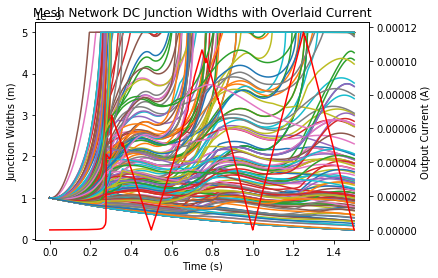

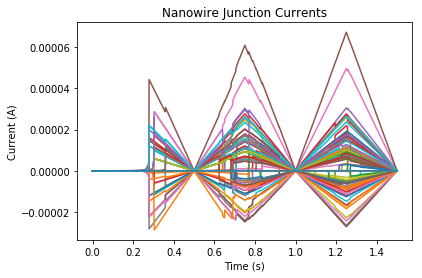

In [83]:
pyplot.plot(times, currents)
pyplot.ylabel('Output Current (A)')
pyplot.xlabel('Time (s)')
pyplot.title('Mesh Network DC Current')
pyplot.show(host)

fig = pyplot.figure()
host = fig.add_subplot(111)
for i in range(len(junctions)):
    host.plot(times, jweights[i])
outputs = host.twinx()
outputs.plot(times, currents, color="red")
outputs.set_ylabel('Output Current (A)')
#outputs.spines['right'].set_position(('outward', 50))
host.set_xlabel('Time (s)')
host.set_ylabel('Junction Widths (m)')
host.set_title('Mesh Network DC Junction Widths with Overlaid Current')
pyplot.show(host)

for i in range(len(junctions)):
    pyplot.plot(times, jcurrents[i])
pyplot.title("Nanowire Junction Currents")
pyplot.xlabel('Time (s)')
pyplot.ylabel('Current (A)')
pyplot.show()

In [113]:
import cProfile
import timeit
def generate():
    electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 80, 20, 20)]
    network = spawn_nanowires(xmax=100, ymax=100, num_nanowires=100)
    connect_electrodes(electrodes, network)
    junctions = create_junctions(network, electrodes=electrodes)
    
print(timeit.timeit(generate, number=10))
#cProfile.run("generate()")

8.44197725900085


In [22]:
import cProfile
def simulate():
    # create network
    nanowires = spawn_nanowires(num_nanowires=100)
    electrodes = [Electrode(0, 0, 20, 20), Electrode(80, 0, 20, 20)]
    connect_electrodes(electrodes, nanowires)
    junctions = create_junctions(nanowires, electrodes=electrodes, w0=0.2, dissolution_rate=1)
    if amplitude == 1:
        plot_network(nanowires, junctions, electrodes, "Replication Test")
    # simulate sinusoidal input
    times = []
    voltages = []
    currents = []
    jweights = []
    jcurrents = []
    for junction in junctions:
        jweights.append([])
        jcurrents.append([])
    timestep = 0.001 # 1 ms
    current_time = 0
    total_time = 1.5 #s
    count = 0
    print('Running simulation...')
    while current_time <= total_time:
        #if(count % 100 == 0):
        #    print('{}s / {}s...'.format(total_time, current_time))
        count += 1

        # set known voltages
        electrodes[0].voltage = 0 
        if current_time <= 0.5:
            electrodes[1].voltage = 1
        elif current_time <= 1:
            electrodes[1].voltage = 0
        elif current_time <= 1.5:
            electrodes[1].voltage = 1

        update_network(nanowires, junctions, electrodes, timestep)

        # store data
        times.append(current_time)
        voltages.append(electrodes[1].voltage)
        for i in range(len(junctions)):
            jweights[i].append(junctions[i].w)
            jcurrents[i].append(junctions[i].current)
        current = calculate_current_from_electrode(electrodes[1], nanowires, junctions)
        currents.append(current)
        current_time += timestep

    print('Simulation complete.')
cProfile.run('simulate()')

Running simulation...
Simulation complete.
         4343907 function calls in 11.934 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    0.000    0.000    0.000    0.000 <ipython-input-1-be0cc239ca8e>:10(__init__)
      205    0.000    0.000    0.001    0.000 <ipython-input-1-be0cc239ca8e>:18(__init__)
   870580    1.167    0.000    1.167    0.000 <ipython-input-1-be0cc239ca8e>:34(resistance)
   307705    0.810    0.000    1.573    0.000 <ipython-input-1-be0cc239ca8e>:37(dwdt)
   307705    0.433    0.000    2.006    0.000 <ipython-input-1-be0cc239ca8e>:41(update_w)
        1    0.000    0.000    0.001    0.001 <ipython-input-2-8b9021dd7ec2>:9(spawn_nanowires)
     1501    2.578    0.002   11.579    0.008 <ipython-input-20-fc5bf0992b2b>:1(update_network)
     1501    0.019    0.000    0.019    0.000 <ipython-input-20-fc5bf0992b2b>:28(calculate_current_from_electrode)
        1    0.231    0.231   11.904   11.904 <ip